# Assignment 1  
## Non-linearity and low wavenumber update 

The goal for this notebook is to understand the important of low-wavenumber in the inversion. It will only requires minipulation of the data/initial model. Thus, the main inversion code is imported as class and we will run it as is without modification.



### Tasks: 

     - Aplpy FWI using the full data spectrum on: 
     
             1-  A smooth initial model (vsmooth.npy)
               
             2-  A v(z) model (vz.npy)
 
     - Apply a multi-scale approach to improve the inversion of v(z), 
         why did you decide on chosing these frequency bands ? 
 
     - Compare the inversion with and without the multi-scale approach, explain the reason for this behavior. 


### Note: 
A time estimate for the inversion is about 10 min for the smooth model, but it takes much more timme for vz model

In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import fwi
import torch
import time
import matplotlib.pylab  as plt
import deepwave
from scipy import signal
from  scipy.ndimage import gaussian_filter
import math
import numbers
%matplotlib inline 



In [2]:
# torch.cuda.current_device()
# torch.cuda.get_device_name()

'RTX A6000'

####  Functions

In [3]:
def plot_model(m,par):
    """
    plot the velocity model 
    
    Arguments
    ----------
    m: 2D numpy array 
        The velocity model  
    par: dictionary 
        A dictionary containing the parameter for the model (nx,dx,nz,dz)        
    """
    

    vmin, vmax = np.percentile(m.T,[2,98])
    plt.figure(figsize=(10,3))
    plt.imshow(m,cmap='jet',vmin=vmin,vmax=vmax,extent=[par['ox'],par['dx']*par['nx'],par['nz']*par['dz'],par['oz']])
    plt.axis('tight')
    plt.xlabel('Distance')
    plt.ylabel('Depth')
    plt.colorbar()
    plt.show(block=False)
    
    
def plot_shot(data,idx,par):
    """
    plot a shot gather 
    
    Arguments
    ----------
    data: 3D numpy array 
         array containing the shot gathers
    idx : int 
        the index of the shot gather to be plotted
    par: dictionary 
        A dictionary containing the parameter for the shot (nt,dt,nt,dt)        
    """
    vmin, vmax = np.percentile(data[:,idx].cpu().numpy(), [2,98])
    plt.figure()
    plt.imshow(data[:,idx].cpu().numpy(), aspect='auto',
           vmin=vmin, vmax=vmax,cmap='gray',extent=[par['orec']+idx*par['ds'],par['orec']+idx*par['ds']+par['dr']*par['nr'],
                                                    par['nt']*par['dt'],par['ot']])
    plt.ylabel('Time (s)')
    plt.xlabel('Distance (km)')
    
    
def mask(m,value):
    """
    Return a mask for the model (m) using the (value)
    """
    msk = m > value
    msk = msk.astype(int)
    return msk



#### Define the parameters and I/O files 

In [4]:
device = torch.device('cuda:0')



# I/O file 
# input files 
path = './input_files/'
# Fvel = path + 'vsmooth.npy'   # initial vel
Fvel = path + 'vel_true.npy'   # linear vel
Fwav = path + 'wavelet15.npy' # wavelet
Fdata = path + 'observed_data.npy' # observed data
# output file 

par = {'nx':601,   'dx':0.015, 'ox':0,
       'nz':211,   'dz':0.015, 'oz':0,
       'ns':30,    'ds':0.3,   'os':0,   'sz':0.03,
       'nr':601,   'dr':0.015,  'orec':0, 'rz':0.03,
       'nt':3000,  'dt':0.0015,  'ot':0,
       'freq':15,
       'num_batches':5,
       'FWI_itr': 150
      }



# Do Not touch the below lines 
nx = par['nx']
nz = par['nz']
dx = par['dx']
dt = par['dt']
fs = 1/par['dt']
nt = par['nt']
num_dim = 2
num_shots = par['ns']
num_batches = par['num_batches']
num_sources_per_shot=1
num_receiver_per_shot= par['nr']
source_spacing = par['ds']
receiver_spacing = par['dr']
receivers_depth = par['sz']
source_depth = par['rz']
orec = par['orec']
os = par['os']
FWI_itr = par['FWI_itr']
freq=par['freq']


#### Loading the input files

vel shape (211, 601) (nx,nz)


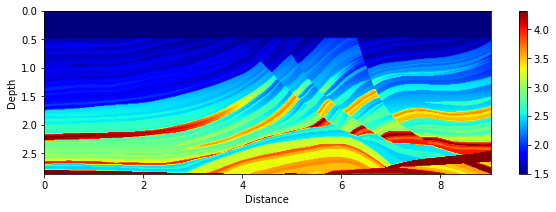

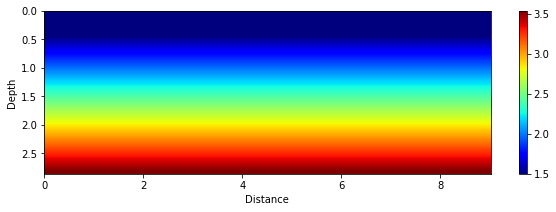

In [5]:

#  Load the velocity model 
vel = np.load(Fvel)
vel_init = np.load('./input_files/vz.npy')

print(f'vel shape {vel.shape} (nx,nz)')

# #  load data 
# data = np.load(Fdata)
# print(f'data shape {data.shape} (nt,ns,nr)')

#  load wavelet 
# wavl = np.load(Fwav)
# print(f' wavl shape {wavl.shape} (nt,1,1)')


vel = np.pad(vel, ((20, 0),(0,0)), 'constant', constant_values=(1.5, 0))
vel_init = np.pad(vel_init, ((20, 0),(0,0)), 'constant', constant_values=(1.5, 0))

vel = vel[:-40,]
vel_init = vel_init[:-40,]
par['nz'] = par['nz'] -20
plot_model(vel,par)

plot_model(vel_init,par)


#### Convert arrays to tensor 

In [6]:
# Get a mask for the water layer (P.S water veocity = 1.5 km/s)
# msk_water = mask(vel,1.5)
msk_water = np.ones_like(vel)
msk_water[:40,] =  0



# convert to tensor
vel = torch.tensor(vel,dtype=torch.float32)
vel_init = torch.tensor(vel_init,dtype=torch.float32)
# data = torch.tensor(data)
# wavl = torch.tensor(wavl)






### Initialize FWI class 

In [7]:

# initialize the fwi class
inversion = fwi.fwi(nx,nz,dx,nt,dt,num_dim,num_shots,
                    num_sources_per_shot,source_spacing,os,
                    num_receiver_per_shot,receiver_spacing,orec,
                    source_depth,receivers_depth,num_batches)


#### Forward modelling 
    
You don't need to do this step, it is already done to create the observed data 

In [8]:
# #Ricker wavelet
wavl = inversion.Ricker(freq)
# Foeward modelling 
data = torch.zeros((nt,num_shots,num_receiver_per_shot),dtype=torch.float32)
data = inversion.forward_modelling(vel,wavl.repeat(1,num_shots,num_sources_per_shot),device)


torch.Size([3000, 30, 601])


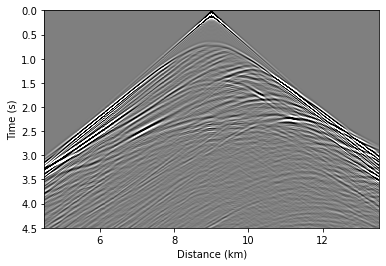

In [9]:
plot_shot(data,par['ns']//2,par)
print(data.shape)

#### Filter data and wavelet for multi-scaling 

In [20]:
def butter_bandpass(lowcut, highcut, fs,btype ,order=7):
    nyq = 0.5 * fs
    if lowcut != None: low = lowcut / nyq
    if highcut != None: high = highcut / nyq

    if btype == 'band': b, a = signal.butter(order, [low, high], btype=btype, analog=False)
    if btype == 'low':  b, a = signal.butter(order, high, btype=btype, analog=False)
    if btype == 'high': b, a = signal.butter(order,low, btype=btype, analog=False)
    
    return b, a        

def butter_bandpass_filter(data,lowcut=None,highcut=None,fs=None,btype='band',order=7):
    """
    This functions create a butterworth filter and apply the bandpass/high_cut/low_cut filters to the data  

    Arguments:
    ----------
            data   :     1D array that will be filtered 
            lowcut :   The lower band of frequency  [None for law_pass_filter] 
            highcut:  The high band of frequency  [None for high_pass filter]
            btype  :  filtertype ['band','low','high']
            order  :  order of the butterworth filter 
    for more details - check the scipy documentation 
    """
    b, a = butter_bandpass(lowcut, highcut, fs,btype, order=order)
    y = signal.filtfilt(b, a, data)
    return y 







cut= 10 #<the highest freq>
wavl_f = torch.from_numpy(butter_bandpass_filter(
         wavl.view(wavl.shape[0]).numpy(),lowcut=None,highcut=cut,fs=fs,btype='low').copy()).view(wavl.shape[0],1,1)
# Filtering the data  
# Check better method to filter 2D faster 
data_f = torch.zeros_like(data)
for ix in range(data.shape[1]):
    for s in range(data.shape[2]):
        data_f[:,ix,s] =torch.from_numpy(butter_bandpass_filter(
        data[:,ix,s].view(data[:,ix,s].shape[0]).numpy(),lowcut=None,highcut=cut,fs=fs,btype='low').copy()).view(data[:,ix,s].shape[0])


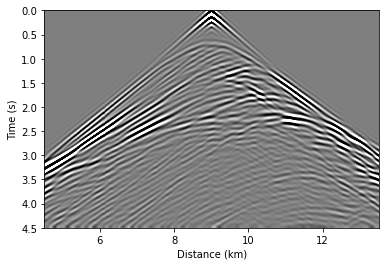

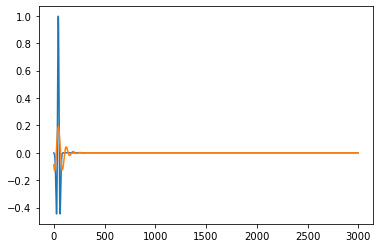

In [21]:
# Plotting giltered data 
plot_shot(data_f,par['ns']//2,par)

plt.figure()
plt.plot(wavl[:,0,0])
plt.plot(wavl_f[:,0,0])


### Run inversion 

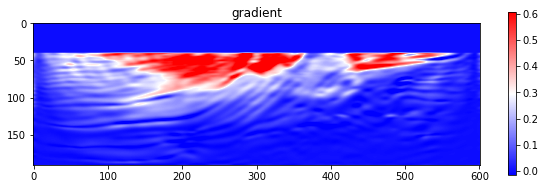

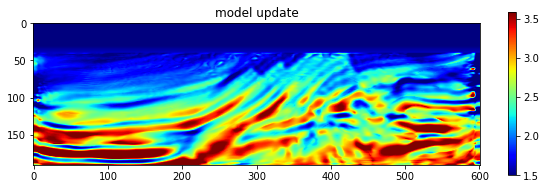

Iteration:  0 Objective:  2.452614900180696e-13
Iteration:  1 Objective:  2.1256803758059988e-13
Iteration:  2 Objective:  1.9640444666132496e-13
Iteration:  3 Objective:  1.9204024153773695e-13
Iteration:  4 Objective:  1.9072509074998488e-13


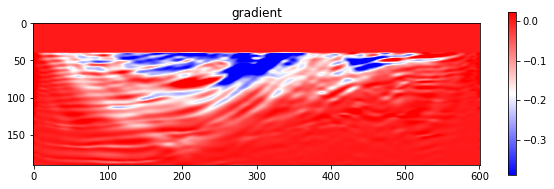

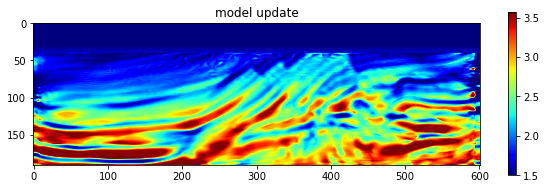

Iteration:  5 Objective:  1.8713576830720405e-13
Iteration:  6 Objective:  1.8028490823157085e-13
Iteration:  7 Objective:  1.717997895637688e-13
Iteration:  8 Objective:  1.6416588479784867e-13
Iteration:  9 Objective:  1.591741908906711e-13


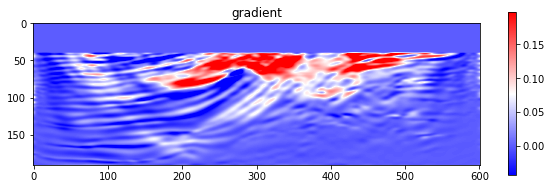

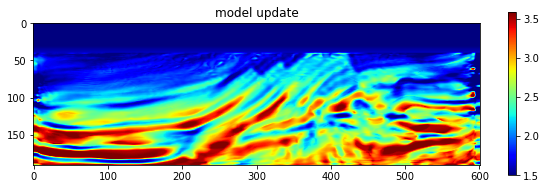

Iteration:  10 Objective:  1.5685821646562945e-13
Iteration:  11 Objective:  1.5566775909210857e-13
Iteration:  12 Objective:  1.53844114097329e-13
Iteration:  13 Objective:  1.506898565753782e-13
Iteration:  14 Objective:  1.467761984408301e-13


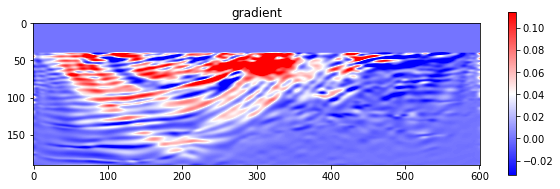

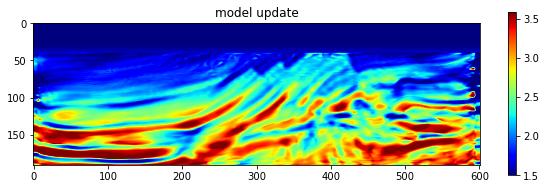

Iteration:  15 Objective:  1.4328575862431175e-13
Iteration:  16 Objective:  1.410969136802576e-13
Iteration:  17 Objective:  1.4017324119193573e-13
Iteration:  18 Objective:  1.3966962081248674e-13
Iteration:  19 Objective:  1.3869137229730738e-13


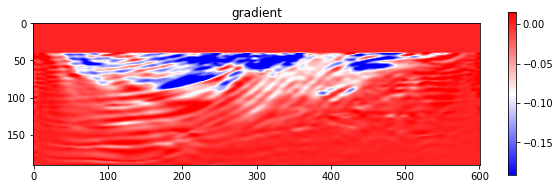

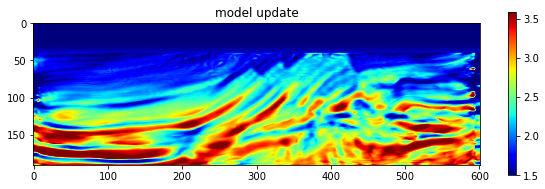

Iteration:  20 Objective:  1.3696951355773347e-13
Iteration:  21 Objective:  1.349126786985089e-13
Iteration:  22 Objective:  1.3315998118339136e-13
Iteration:  23 Objective:  1.3204114383369263e-13
Iteration:  24 Objective:  1.3135403070687994e-13


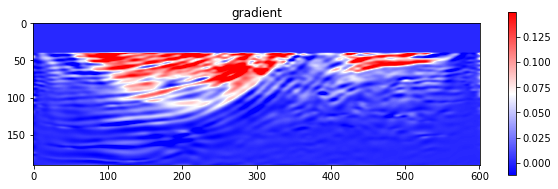

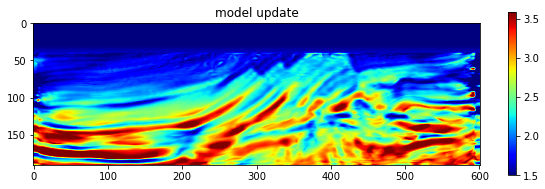

Iteration:  25 Objective:  1.306132885360448e-13
Iteration:  26 Objective:  1.2950909808006998e-13
Iteration:  27 Objective:  1.2814115342278144e-13
Iteration:  28 Objective:  1.2686855248810174e-13
Iteration:  29 Objective:  1.259632606147353e-13


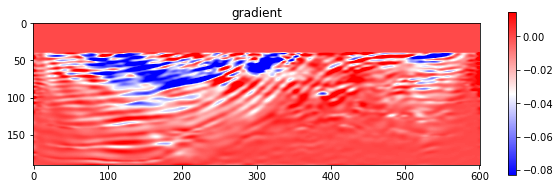

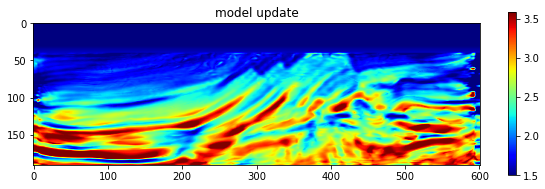

Iteration:  30 Objective:  1.2537944993210384e-13
Iteration:  31 Objective:  1.2483769782343536e-13
Iteration:  32 Objective:  1.2411477891987634e-13
Iteration:  33 Objective:  1.2323469135888838e-13
Iteration:  34 Objective:  1.2239955414234532e-13


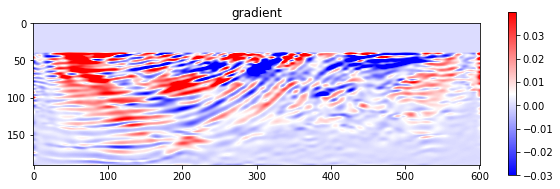

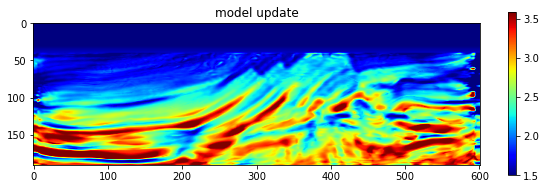

Iteration:  35 Objective:  1.2176453184772288e-13
Iteration:  36 Objective:  1.212905559273619e-13
Iteration:  37 Objective:  1.2081348494861165e-13
Iteration:  38 Objective:  1.2022766340976342e-13
Iteration:  39 Objective:  1.195840894705055e-13


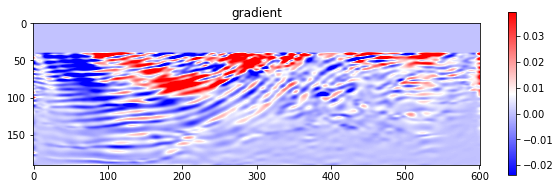

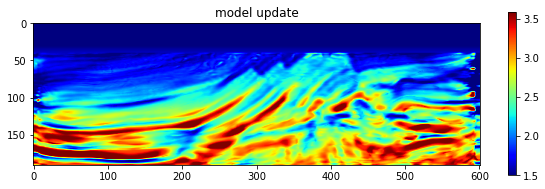

Iteration:  40 Objective:  1.1901208642715877e-13
Iteration:  41 Objective:  1.1857192236798628e-13
Iteration:  42 Objective:  1.1819585329193253e-13
Iteration:  43 Objective:  1.1777707681467822e-13
Iteration:  44 Objective:  1.1728865898256655e-13


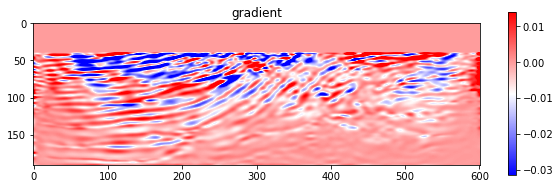

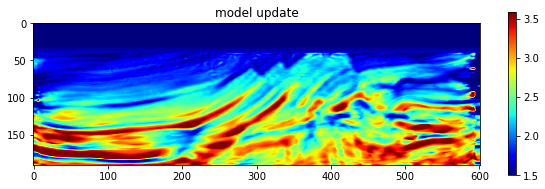

Iteration:  45 Objective:  1.1680305838203744e-13
Iteration:  46 Objective:  1.163986052319212e-13
Iteration:  47 Objective:  1.160741340148824e-13
Iteration:  48 Objective:  1.1576160935053165e-13
Iteration:  49 Objective:  1.1541224214110715e-13


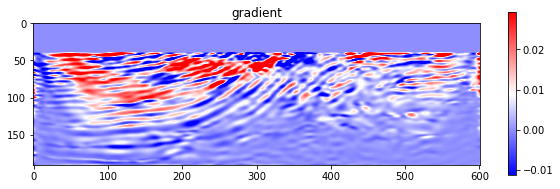

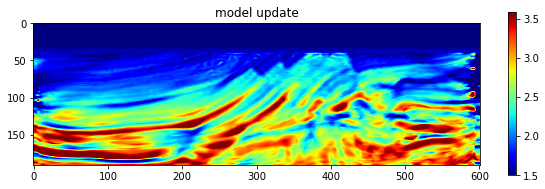

Iteration:  50 Objective:  1.1504490766880548e-13
Iteration:  51 Objective:  1.1471106657330414e-13
Iteration:  52 Objective:  1.144272664902607e-13
Iteration:  53 Objective:  1.1416051887451137e-13
Iteration:  54 Objective:  1.1387679502443317e-13


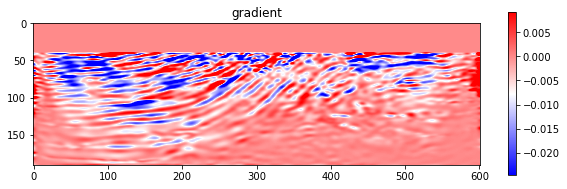

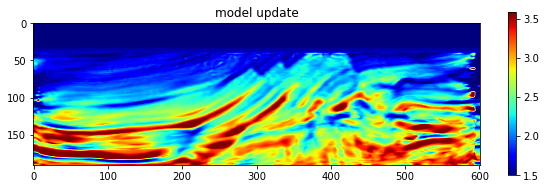

Iteration:  55 Objective:  1.1358267977415806e-13
Iteration:  56 Objective:  1.1331045863150358e-13
Iteration:  57 Objective:  1.1307292179397327e-13
Iteration:  58 Objective:  1.1284858003569528e-13
Iteration:  59 Objective:  1.1261318280338974e-13


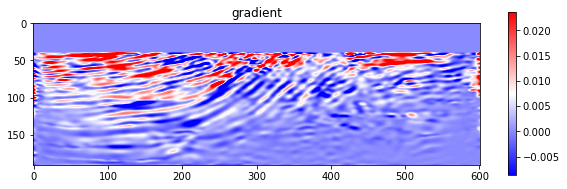

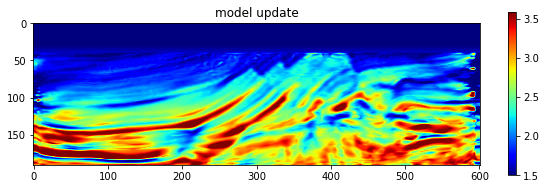

Iteration:  60 Objective:  1.1237057393257126e-13
Iteration:  61 Objective:  1.1214197837483217e-13
Iteration:  62 Objective:  1.1193494658186427e-13
Iteration:  63 Objective:  1.1173652911396995e-13
Iteration:  64 Objective:  1.1153289900531823e-13


In [ ]:
# v_inv,loss  = inversion.run_inversion(vel,data,wavl,msk_water,
#                                       FWI_itr,[0.5,2],device) 


# Freq (5, 6.5, 10, all  )

## For filtered data 
vel_init = torch.from_numpy(v_inv[-1,]) ## use for subsequent inversion 
v_inv,loss  = inversion.run_inversion(vel_init,data_f,wavl_f,msk_water,
                                      FWI_itr,[0.5,3],device) 

#### Plotting the objective function and the inversion results 
Note the inversion save the model every 5 iteration. Thus `v_inv` will have the sape of `(#update//5,nz,nx)`

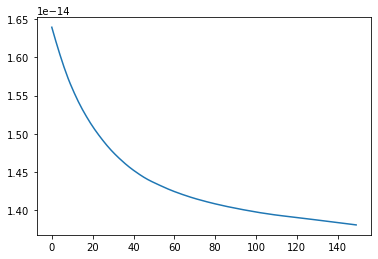

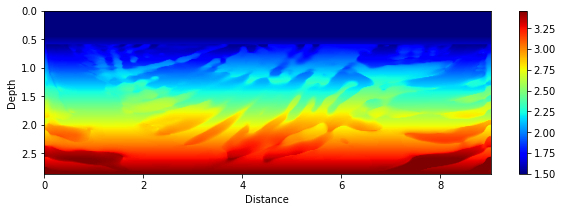

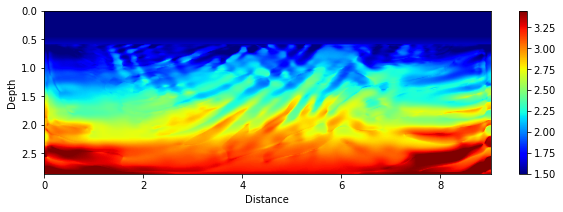

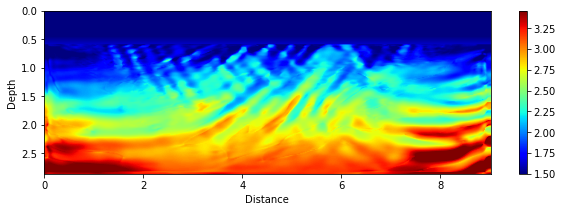

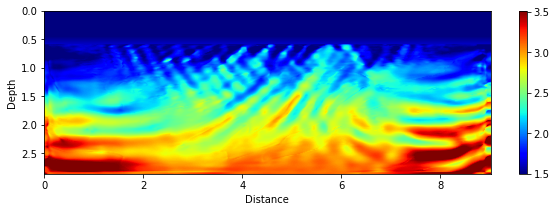

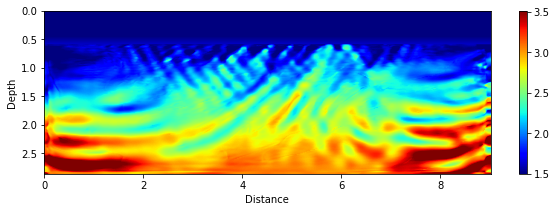

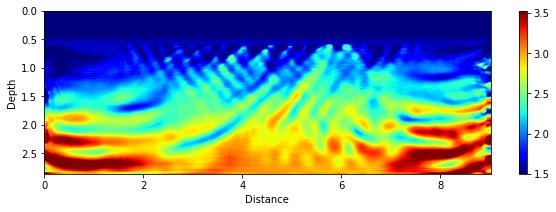

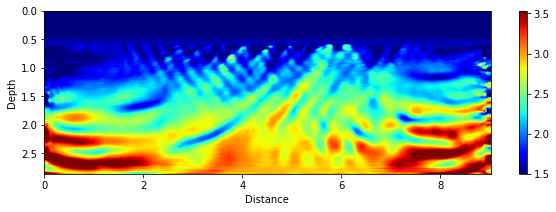

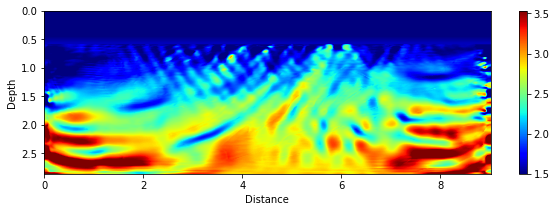

In [13]:

## plotting the objective 
plt.plot(loss)


for i in range(0,v_inv.shape[0],2):
    plot_model(v_inv[i,:,:],par)



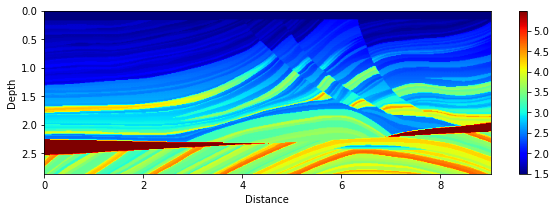

In [14]:
vel = np.load('./input_files/vel_true.npy')
vel_init = np.load('./input_files/vz.npy')
plot_model(vel,par)

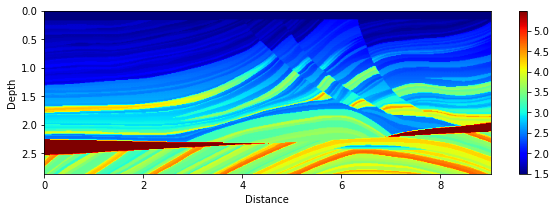

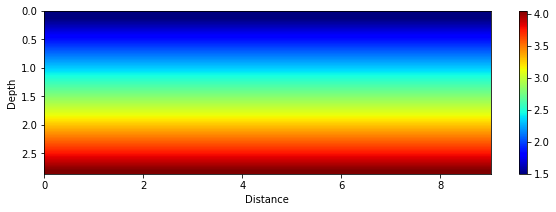

(None, None)

In [15]:
plot_model(vel,par),plot_model(vel_init,par)